In [63]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sn

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

In [65]:
import tensorflow as tf
from tensorflow import keras

df = pd.read_csv("D:/diabetes.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [66]:
# imbalanced 확인
df['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [67]:
# 데이터 분할 X
X=df.drop('Outcome',axis=1)
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [68]:
# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [69]:
# 데이터 분할 y
y=df['Outcome']
y.value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [70]:
# 원 핫 인코딩
#Y = pd.get_dummies(y).values
#Y

# 정수 인코딩 (원-핫 말고)
Y = y.values  # 0 또는 1의 정수값을 그대로 유지

In [71]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=0) 

In [72]:
X_train.shape,X_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

In [73]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [74]:
# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [75]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([614, 8]),
 torch.Size([154, 8]),
 torch.Size([614]),
 torch.Size([154]))

In [76]:
# 모델 정의
class DiabetesEvaluationDense(nn.Module):
    def __init__(self):
        super(DiabetesEvaluationDense, self).__init__()
        self.fc1 = nn.Linear(8, 16)   # 입력 특성 수: 8개 (diabetes.csv 기준)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 2)   # 2개의 클래스
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model = DiabetesEvaluationDense()

In [77]:
# 손실 함수 및 최적화 기법 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [78]:
# 모델 학습
# Variables to store loss and accuracy
train_losses = []
test_accuracies = []

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)


        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss over an epoch
    train_losses.append(running_loss / len(train_dataloader))

    # Evaluate on test data
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

Epoch 1/30, Loss: 0.5700, Accuracy: 68.83%
Epoch 2/30, Loss: 0.5335, Accuracy: 78.57%
Epoch 3/30, Loss: 0.4757, Accuracy: 81.17%
Epoch 4/30, Loss: 0.4911, Accuracy: 83.12%
Epoch 5/30, Loss: 0.4708, Accuracy: 79.22%
Epoch 6/30, Loss: 0.5145, Accuracy: 75.32%
Epoch 7/30, Loss: 0.5129, Accuracy: 75.32%
Epoch 8/30, Loss: 0.5213, Accuracy: 74.68%
Epoch 9/30, Loss: 0.4824, Accuracy: 79.22%
Epoch 10/30, Loss: 0.4539, Accuracy: 77.27%
Epoch 11/30, Loss: 0.4862, Accuracy: 75.97%
Epoch 12/30, Loss: 0.4804, Accuracy: 79.87%
Epoch 13/30, Loss: 0.4551, Accuracy: 78.57%
Epoch 14/30, Loss: 0.5030, Accuracy: 78.57%
Epoch 15/30, Loss: 0.4767, Accuracy: 77.92%
Epoch 16/30, Loss: 0.4968, Accuracy: 76.62%
Epoch 17/30, Loss: 0.4447, Accuracy: 78.57%
Epoch 18/30, Loss: 0.4769, Accuracy: 79.87%
Epoch 19/30, Loss: 0.4507, Accuracy: 74.68%
Epoch 20/30, Loss: 0.4972, Accuracy: 72.08%
Epoch 21/30, Loss: 0.5167, Accuracy: 70.78%
Epoch 22/30, Loss: 0.4711, Accuracy: 77.27%
Epoch 23/30, Loss: 0.4485, Accuracy: 75.3

In [79]:
# 모델 평가
# Evaluation
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate metrics
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

# Calculate specificity for each class
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')

Confusion Matrix:
[[105   2]
 [ 43   4]]
F1 Score: 0.62
Precision: 0.70
Recall: 0.71
Specificity: 0.53


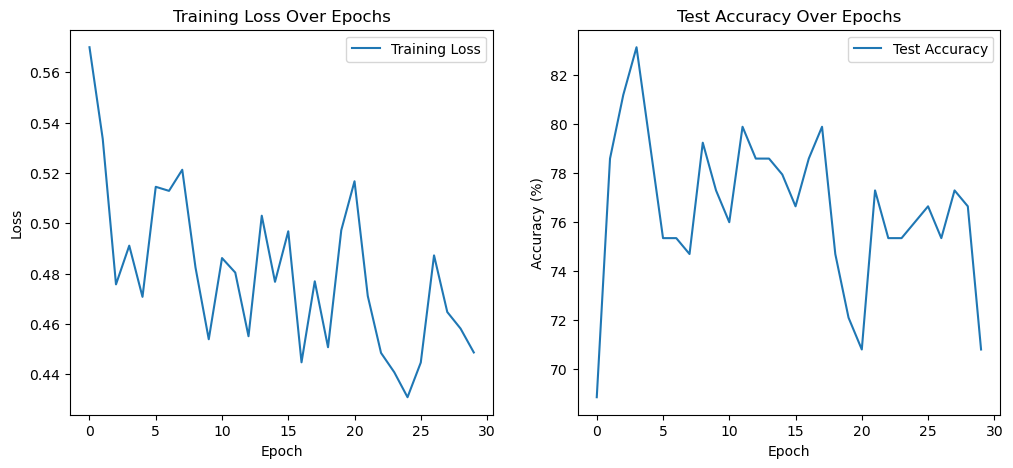

In [80]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()